In [21]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from itertools import combinations
from os import listdir
from sklearn.utils import resample

In [3]:
dfs = []
for dir in listdir("alpaca_farm/bon_outs/"):
    if 'eli' in dir:
        dfs.append(pd.read_json("alpaca_farm/bon_outs/"+dir, orient='records'))

In [6]:
alldfs = pd.concat(dfs).reset_index(drop=True).drop(columns=['input', 'scorer_name_or_path'])

In [7]:
alldfs

,instruction,output,top_sequence,top_index,top_scores
0,"Gorillaz and their virtual band ""history""I am ...",[Gorillaz is a British virtual band created in...,[Below is an instruction that describes a task...,"[1, 0]","[0.39429283142089805, 0.7290570735931391]"
1,If a RAR or ZIP file just make another file/gr...,"[Yes, you can keep compressing RAR and ZIP fil...",[Below is an instruction that describes a task...,"[1, 0]","[1.037175416946411, 1.441125512123108]"
2,Why do Catalonia and the rest of Spain think e...,[The conflict between Catalonia and the rest o...,[Below is an instruction that describes a task...,"[0, 1]","[1.635269045829773, 0.12795141339302002]"
3,Who chooses where the Olympics are going to be...,[The International Olympic Committee (IOC) is ...,[Below is an instruction that describes a task...,"[1, 0]","[-0.598800957202911, 2.12459659576416]"
4,How could the governments of USA / UK have giv...,[It is understandable that you may be confused...,[Below is an instruction that describes a task...,"[0, 1]","[0.7304080724716181, 0.454102754592895]"
...,...,...,...,...,...
16695,Pangaea: Why was there just a single giant lan...,[The hypothesis of a single super-continent is...,[Below is an instruction that describes a task...,"[0, 1]","[2.8094208240509033, 2.256419658660888]"
16696,"All the different FPS ""netcode"" terminology li...",[Netcode is a term used to refer to the networ...,[Below is an instruction that describes a task...,"[0, 1]","[1.205457210540771, 0.6027202010154721]"
16697,Where do last names come from?There's a few qu...,[Last names are thought to have originated in ...,[Below is an instruction that describes a task...,"[1, 0]","[1.125969529151916, 1.569443464279174]"
16698,"Why is the skin on penises so dark, compared t...",[The skin on penises is darker than other area...,[Below is an instruction that describes a task...,"[0, 1]","[1.840420961380004, 1.813018083572387]"


In [ ]:
p = pd.read_json("pftrain2.jsonl", orient='records', lines=True)

In [2]:
test_df = pd.read_json("output/testsetlarge.jsonl", lines=True, orient="records")
# crafted to not include stuff from earlier training
train_df = pd.read_json("output/trainsetlarge.jsonl", lines=True, orient="records")

In [10]:
train_df['dist'] = (train_df.score_a-train_df.score_b).abs()
test_df['dist'] = (test_df.score_a-test_df.score_b).abs()

In [13]:
train_df = train_df[train_df.dist>0.05]
test_df = test_df[test_df.dist>0.05]

(array([8.5606e+04, 4.5215e+04, 2.3596e+04, 1.1905e+04, 5.7720e+03,
        2.6680e+03, 1.1490e+03, 3.5700e+02, 8.2000e+01, 1.4000e+01]),
 array([0.05000001, 0.136257  , 0.22251398, 0.30877097, 0.39502795,
        0.48128494, 0.56754192, 0.6537989 , 0.74005589, 0.82631287,
        0.91256986]),
 <BarContainer object of 10 artists>)

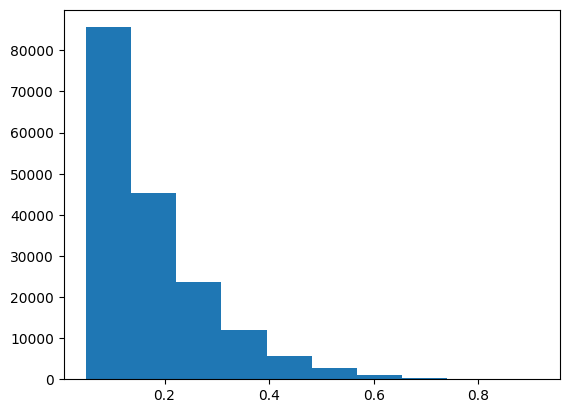

In [18]:
plt.hist(train_df.dist)

In [14]:
train_df.to_json("output/trainsetbalanced.jsonl", lines=True, orient="records")
test_df.to_json("output/testsetbalanced.jsonl", lines=True, orient="records")

In [15]:
# A, B, C, D
CLASSES = [71, 272, 205, 309]
#CLASSES = [71, 272]
def getclass(val):
    if val<1.1:
        return CLASSES[0]
    elif val<1.7:
        return CLASSES[1]
    elif val<2.1:
        return CLASSES[2]
    else:
        return CLASSES[3]
    
def pairlabel(val):
    if val==1:
        return CLASSES[0]
    return CLASSES[1]

In [ ]:
train_df['label'] = [getclass(v) for v in train_df['sco']]
test_df['label'] = [getclass(v) for v in test_df['sco']]

In [ ]:
train_df.to_json("output/trainsetlarge.jsonl", lines=True, orient="records")
test_df.to_json("output/testsetlarge.jsonl", lines=True, orient="records")

In [ ]:
len(p['inp'].unique())

In [ ]:
groups = []
lens = set()
shown = 0
for _, d in prefdataset.groupby('inp'):
    if len(d)==6:
        groups.append(d)
    else:
        if shown<8:
            print(d)
            shown = shown+1

In [6]:
# process raw data into single uniform file
base = "output/rawdata/"
allfiles = [
    "bigdsetp1",
    "bigdsetp2",
    "bigdsetp3",
    "bigdsetp4",
    "bigdsetp5",
    "biggerdset",
    "biggerdset2",
    "biggerdset3",
    "biggerdset4",
    "biggerdset6",
    
]
fulldset = pd.concat([pd.read_json(base+f+".jsonl", orient='records', lines=True) for f in allfiles])
fulldset = fulldset[fulldset['ver']=='first'].drop(columns=['stats', 'ver', 'pref', 'prefix']).reset_index(drop=True)

In [7]:
smallset = fulldset.loc[:2000]

In [8]:
smallset.to_json("output/smallrewset.jsonl", orient='records', lines=True)

In [4]:
smallset

,inp,hyps,scos
0,Why are different tiers (regular < mid < premi...,[Is this a practical or theoretical issue? I h...,"[0.3256509602, 0.9307213426000001, 0.765635073..."
1,Stars and VisibilityWhy do stars in the night'...,[The ephemeris of a star can provide some info...,"[0.7836418152, 0.7945138216000001, 0.758988022..."
2,How do we know all the money the government is...,[JPMorgan Chase’s record $13 billion mortgage ...,"[0.721021533, 0.7394787073, 0.8426040411, 0.67..."
3,What are good and bad sides of manual and auto...,[The driver has more control over the gearshif...,"[0.8687275648, 0.8893937469000001, 0.553276300..."
4,How do muscles grow?I've been working out late...,[Muscles are made up of proteins and the more ...,"[0.8180243969000001, 0.7415654063, 0.895186185..."
...,...,...,...
1996,Why do University computers get a 200+Mbps con...,"[If every person had 1Gb of bandwidth, that wo...","[0.892678678, 0.7492083311000001, 0.8366983533..."
1997,so why do companies make mail-in rebates?why d...,[If you can sell more products to people by ha...,"[0.49159574510000004, 0.8631223440000001, 0.56..."
1998,Why do people keep buying EA games if they kno...,[I think this is the case in that many people ...,"[0.5311492085, 0.8092612624000001, 0.745661974..."
1999,The enormous salaries of professional athletes...,"[I think the owners started to pay out more, t...","[0.46389752630000003, 0.8252944350000001, 0.69..."


In [6]:
len(fulldset['inp'].unique())

55208

In [8]:
import numpy as np
def get_traindict(row):
    inptemplate = """
    Write a long, detailed, response to properly answer the question. 

    Question: {inp} \n\n
    Response:"""
    res = {}
    res['input'] = inptemplate.format(inp=row['inp'])
    # take hyp with highest steamSHP
    res['output'] = row['hyps'][int(np.argmax(row['scos']))]
    res['sco'] = max(row['scos'])
    return res

In [18]:
allres = pd.DataFrame([get_traindict(r) for _, r in fulldset.iterrows()])

In [23]:
allres = allres.drop_duplicates(subset=['input']).reset_index()

In [24]:
len(allres)

55208

In [26]:
train = allres.loc[:50000]
test = allres.loc[50000:]

In [27]:
train.to_json("output/llamaftunetrain.jsonl", lines=True, orient='records')
test.to_json("output/llamaftunetest.jsonl", lines=True, orient='records')

In [28]:
allres['input'][0]

"\n    Write a long, detailed, response to properly answer the question. \n\n    Question: Why are different tiers (regular < mid < premium) of gas' prices almost always 10 cents different?I've noticed that the difference in price between regular gas and midrange, and between midrange and premium, is almost always 10 cents. This seems to hold true no matter what the price for regular gas. This doesn't seem to make sense, as the difference between $2 and $2.10 and the difference between $4 and $4.10 /gal are proportionally very different. Is this just an arbitrary convention that undermines arguments of a rational basis for gasoline prices?  \n\n\n    Response:"

In [5]:
sum([max(m) for m in fulldset['scos']])/len(fulldset)

0.8649267119261091

(array([3.4000e+01, 2.8000e+02, 1.0840e+03, 3.2800e+03, 1.3202e+04,
        3.3712e+04, 1.4602e+04, 5.5800e+02, 3.6000e+01, 1.2000e+01]),
 array([-1.64684582, -1.03905058, -0.43125534,  0.1765399 ,  0.78433514,
         1.39213037,  1.99992561,  2.60772085,  3.21551609,  3.82331133,
         4.43110657]),
 <BarContainer object of 10 artists>)

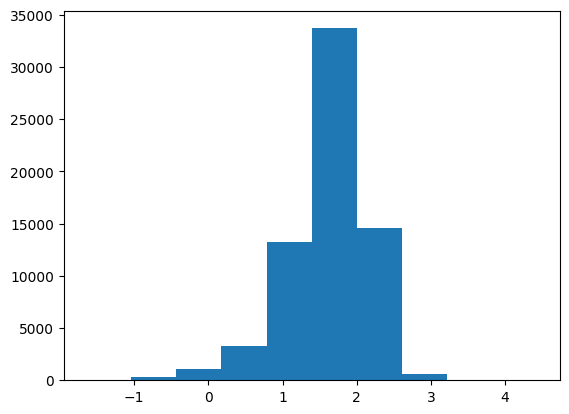

In [13]:
plt.hist(fulldf.sco)

In [10]:
fulldf = random_prefix_dataframe(alldfs)

4
20


In [11]:
fulldf

,inp,hyp,pflen,sco
0,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a British virtual band created in ...,33,0.394293
1,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a virtual band created by Damon Al...,12,0.729057
2,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a British virtual band created in ...,29,0.394293
3,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a virtual band created by Damon Al...,19,0.729057
4,If a RAR or ZIP file just make another file/gr...,"Yes, you can keep compressing RAR and ZIP file...",13,1.037175
...,...,...,...,...
66795,"Why is the skin on penises so dark, compared t...",The skin on the penis is darker than other are...,29,1.813018
66796,Why is 16:9 the standard ratio for visual medi...,The 16:9 ratio is the most commonly used aspec...,35,1.719491
66797,Why is 16:9 the standard ratio for visual medi...,The 16:9 ratio is the most commonly used ratio...,16,1.750482
66798,Why is 16:9 the standard ratio for visual medi...,The 16:9 ratio is the most commonly used aspec...,17,1.719491


In [16]:
fulldf['label'] = [getclass(c) for c in fulldf['sco']]

In [27]:
def balance(indf):
    # Identify the number of samples for the smallest class
    n_samples = indf['label'].value_counts().min()
    
    # Split the DataFrame per classes
    dfs = [indf[indf['label'] == i] for i in indf['label'].unique()]
    
    # Resample each DataFrame
    dfs_resampled = [resample(d, 
                              replace=True,  # sample with replacement
                              n_samples=n_samples,  # to match number in smallest class
                              random_state=123  # reproducible results
                             ) for d in dfs]
    
    # Concatenate the DataFrames
    res = pd.concat(dfs_resampled)
    res = res.sample(frac=1, random_state=123).reset_index(drop=True)

    return res

In [30]:
newtrain = balance(traindf)
newtest = balance(testdf)

In [34]:
newtrain.to_json('output/apfarm_ppo_train.jsonl', orient='records', lines=True)
newtest.to_json('output/apfarm_ppo_test.jsonl', orient='records', lines=True)

(array([ 9194.,     0.,     0.,     0.,     0., 22624.,     0.,     0.,
        24368., 10614.]),
 array([ 71. ,  94.8, 118.6, 142.4, 166.2, 190. , 213.8, 237.6, 261.4,
        285.2, 309. ]),
 <BarContainer object of 10 artists>)

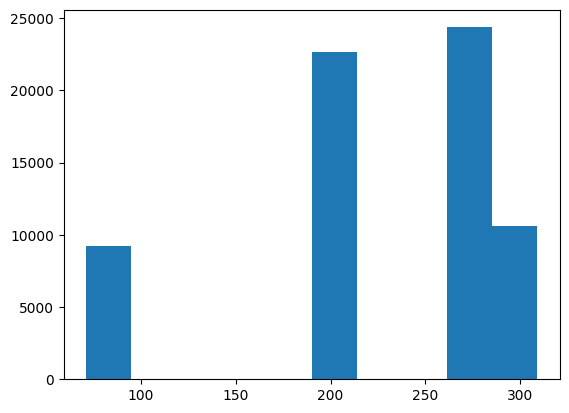

In [17]:
plt.hist(fulldf['label'])

In [19]:
traindf = fulldf.loc[:60000].copy()
testdf = fulldf.loc[60000:].copy()

In [20]:
traindf

,inp,hyp,pflen,sco,label
0,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a British virtual band created in ...,33,0.394293,71
1,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a virtual band created by Damon Al...,12,0.729057,71
2,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a British virtual band created in ...,29,0.394293,71
3,"Gorillaz and their virtual band ""history""I am ...",Gorillaz is a virtual band created by Damon Al...,19,0.729057,71
4,If a RAR or ZIP file just make another file/gr...,"Yes, you can keep compressing RAR and ZIP file...",13,1.037175,71
...,...,...,...,...,...
59996,How do Windfarms work?And how to the wind turb...,Windfarms work by converting the kinetic energ...,31,2.162228,309
59997,How do Windfarms work?And how to the wind turb...,Windfarms work by converting the kinetic energ...,35,1.834873,205
59998,How do Windfarms work?And how to the wind turb...,Windfarms work by converting the kinetic energ...,17,2.162228,309
59999,How do Windfarms work?And how to the wind turb...,Windfarms work by converting the kinetic energ...,17,1.834873,205


In [9]:
def random_prefix_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    new_rows = []
    forbatch = []
    skipped = 0
    for index, row in df.iterrows():
        input_str = row['instruction'] # was inp
        # batches of 3 for consistency
        hyps = row['output'][:3]
        scos = row['top_scores'][:3]
        assert len(hyps)==2
        # get more than 1 prefix per example for robustness
        added = 0
        while added<4:
            for hyp, sco in zip(hyps, scos):
                words = hyp.split(' ')
                if len(words)<=10:
                    skipped = skipped+1
                    continue
                prefix_length = random.randint(10, min(len(words), 35))
                prefix = ' '.join(words[:prefix_length])

                new_row = {
                    'inp': input_str,
                    'hyp': prefix,
                    'pflen':prefix_length,
                    'sco': sco
                }
                new_rows.append(new_row)
                added = added+1

    print(added)
    print(skipped)
    new_df = pd.DataFrame(new_rows)
    return new_df

In [ ]:
# Function to construct a DataFrame with pairs
def construct_pair_dset(row, k):
    all_pairs = list(combinations(range(len(row['hyps'])), 2))
    pairs_indices = random.choices(all_pairs, k=k)  # sample n unique pairs
    pairs = [(row['hyps'][i], row['hyps'][j]) for i, j in pairs_indices]
    scores = [(row['scos'][i], row['scos'][j]) for i, j in pairs_indices]
    
    # Truncate pairs to 5 to 25 words
    truncated_pairs = []
    deleted = []
    for i in range(len(pairs)):
        pair = pairs[i]
        splits = [hyp.split() for hyp in pair]
        try:
            truncation = random.randint(5, min(25, min([len(arr) for arr in splits])))
            truncated_pair = []
            for hyp in pair:
                words = hyp.split()
                truncated_words = words[:min(truncation, len(words))]
                truncated_hyp = ' '.join(truncated_words)
                truncated_pair.append(truncated_hyp)
            truncated_pairs.append(tuple(truncated_pair))
        except:
            print("bad pair")
            deleted.append(i)

    fscores = []
    for i in range(len(pairs)):
        if i not in deleted:
            fscores.append(scores[i])

    label = [score_a > score_b for score_a, score_b in fscores]
    df_temp = pd.DataFrame({'inp': row['inp'], 'hyp_pairs': truncated_pairs,
                            'score_a': [s[0] for s in fscores],
                            'score_b': [s[1] for s in fscores],
                            'label': label})
    return df_temp

k=5
# Create the new DataFrame
df_new = pd.concat([construct_pair_dset(row, k) for _,row in fulldset.iterrows()]).reset_index(drop=True)

# Optionally, split the 'hyp_pairs' column into 'hyp_a' and 'hyp_b'
df_new[['hyp_a', 'hyp_b']] = pd.DataFrame(df_new['hyp_pairs'].tolist(), index=df_new.index)
df_new = df_new.drop('hyp_pairs', axis=1)

In [23]:
df_new['numlab'] = df_new.label

In [24]:
df_new['label'] = [pairlabel(p) for p in df_new.numlab]

In [30]:
trainset = df_new.iloc[:250000]
testset = df_new.iloc[250000:]

In [7]:
fulldset = fulldset.drop_duplicates(subset=['inp'])

In [ ]:
prefdataset = random_prefix_dataframe(fulldset)
prefdataset['label']=(prefdataset.sco>0.85).astype(int)

In [ ]:
len(prefdataset)/len(prefdataset['inp'].unique())

In [ ]:
int((len(prefdataset)/6)*.9)

In [ ]:
trainset = prefdataset.iloc[:49687*6]

In [ ]:
testset = prefdataset.iloc[49687*6:]

In [33]:
trainset.to_json("output/trainsetlarge.jsonl", orient="records", lines=True)

In [34]:
testset.to_json("output/testsetlarge.jsonl", orient="records", lines=True)

In [ ]:
prefdataset.to_json("output/largerpfmdataset.jsonl", orient="records", lines=True)

In [ ]:
prefdataset = pd.read_json("output/prefmetricdataset.jsonl", orient="records", lines=True)
test_exs = pd.read_json("pftest.jsonl", orient="records", lines=True)

In [ ]:
test_exs

In [ ]:
merged_df = prefdataset.merge(test_exs, indicator=True, how='outer')
train_df = merged_df[merged_df['_merge'] == 'left_only'].reset_index(drop=True)

In [ ]:
train_df.to_json("pftrain.jsonl", orient='records', lines=True)

In [ ]:
train_df